## Import Libraries and Dependencies

In [110]:
# Import our dependencies
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import tensorflow as tf

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [111]:
# Load the data
file_path = Path("resources/processed_stroke_db_w_cat.csv")
df = pd.read_csv(file_path, index_col=[0])
print(df.shape)
df

(4909, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


## Process Data

### One-hot Encoding for Categotical Data & StandScaler for Numerical Data

In [112]:
# Generate categorical variable list
cat_labels= df.dtypes[df.dtypes == "object"].index.tolist()
print(cat_labels)

# Check the number of unique values in each column
print(df[cat_labels].nunique())

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64


In [113]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat_labels]))

encode_df.index = df.index

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_labels)
print(encode_df.shape)
encode_df.head()

(4909, 16)


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31112,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56669,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [114]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(cat_labels,1)
df.shape

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(4909, 22)

### Split, Oversample, Resample Data

In [115]:
# Split the preprocessed data into the features and target arrays
y = df["stroke"].values
X = df.drop(["stroke"],1).values

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

In [117]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape

(3681, 21)

In [118]:
# Apply sampling technique to balance the minority class

# Option One: Resample the training data with SMOTE- Instantiate the model
# smote = SMOTE(random_state=1)


# Option Two: Resample the training data with ADASYN- Instantiate the model
smote = ADASYN(random_state=1)


# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 3524, 1: 3542})

## Single Perceptron Model

### Train, Fit, Evaluate, Predict Model

In [119]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=21))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1)                 22        
                                                                 
 dense_15 (Dense)            (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [121]:
# Fit the model to the training data
fit_model = nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
221/221 [==============================] - 1s 1ms/step - loss: 0.6750 - accuracy: 0.6194 - val_loss: 0.5991 - val_accuracy: 0.5936
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6207 - accuracy: 0.6952 - val_loss: 0.5279 - val_accuracy: 0.5782
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.7174 - val_loss: 0.4947 - val_accuracy: 0.6099
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.7293 - val_loss: 0.4791 - val_accuracy: 0.6336
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5372 - accuracy: 0.7406 - val_loss: 0.4621 - val_accuracy: 0.6645
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.7522 - val_loss: 0.4551 - val_accuracy: 0.6783
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5063 - accuracy: 0.7605 - val_loss: 0.4477 - val_accuracy: 0.6897

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.7903 - val_loss: 0.4646 - val_accuracy: 0.7256
Epoch 59/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4619 - accuracy: 0.7920 - val_loss: 0.4714 - val_accuracy: 0.7215
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7886 - val_loss: 0.4674 - val_accuracy: 0.7248
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7897 - val_loss: 0.4710 - val_accuracy: 0.7223
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7884 - val_loss: 0.4720 - val_accuracy: 0.7215
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7904 - val_loss: 0.4716 - val_accuracy: 0.7215
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7901 - val_loss: 0.4740 - val_accuracy:

In [122]:
# Create a DataFrame containing training history
nn_history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
nn_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.674976,0.619445,0.599076,0.593648
2,0.620690,0.695160,0.527900,0.578176
3,0.581142,0.717379,0.494693,0.609935
4,0.556869,0.729267,0.479115,0.633550
5,0.537212,0.740589,0.462092,0.664495
...,...,...,...,...
96,0.461721,0.791112,0.472473,0.722313
97,0.461886,0.790122,0.470279,0.721498
98,0.461870,0.790829,0.476006,0.717427
99,0.461861,0.789414,0.469893,0.721498


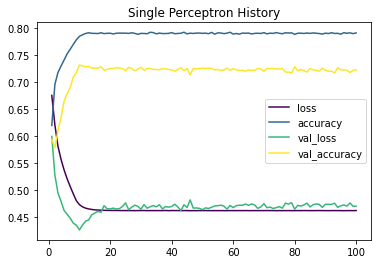

In [123]:
# Plot the history
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")

<AxesSubplot:>

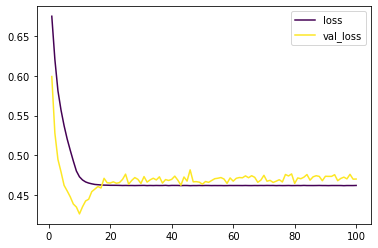

In [124]:
# Plot the loss
nn_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

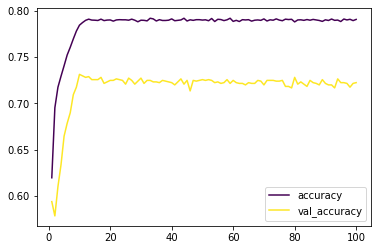

In [125]:
# Plot the accuracy
nn_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [126]:
# Evaluate the model using the test data
nn_model_loss,nn_model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the single perceptron model is: {nn_model_loss}, The accuracy is: {nn_model_accuracy}")

 The loss for the single perceptron model is: 0.47006842494010925, The accuracy is: 0.7223126888275146


In [127]:
# Y_pred: flatten & convert prediction probabilities to binary format so it can be passed through confusion matrix
y_pred_nn = nn_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn.flatten()
y_pred_nn_tf=tf.round(y_pred_nn)

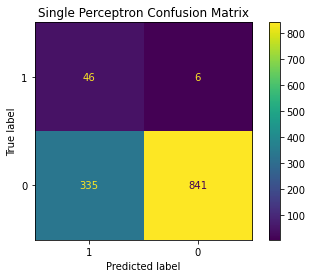

In [128]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test, y_pred_nn_tf, labels=[1,0])

nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=[1,0])
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")
nn_disp

In [157]:
# Advanced Classification Metrics
# Accuracy
nn_accuracy_score = accuracy_score(y_test, y_pred_nn_tf)
print(f'Accuracy Score of the Single Perceptron Model: {nn_accuracy_score}')

# Recall
nn_recall_score = recall_score(y_test, y_pred_nn_tf)
print(f'Recall Score of the Single Perceptron Model: {nn_recall_score}')

# Specificity
nn_specificity_score = 841 / 1176
print(f'Specifity Score of the Deep Learning Model: {nn_specificity_score}')

# Balanced Accuracy Score
nn_bas = balanced_accuracy_score(y_test, y_pred_nn_tf)
print(f'Balanced Accuracy Score of the Single Perceptron Model: {nn_bas}')

# Precision
nn_precision_score = precision_score(y_test, y_pred_nn_tf)
print(f'Precision Score of the Single Perceptron Model: {nn_precision_score}')     
   
# F1 Score
nn_f1_score = f1_score(y_test, y_pred_nn_tf)
print(f'F1 Score Score of the Single Perceptron Model: {nn_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {nn_model_loss}')

# Advanced Classification Metrics DF
nn_acm = {"Model Type": ["Single Perceptron"], "Accuracy":[nn_accuracy_score], "Recall": [nn_recall_score], "Specificity":[nn_specificity_score], 
          "Balanced Accuracy": [nn_bas], "Precision":[nn_precision_score], "F1 Score":[nn_f1_score], "Loss": [nn_model_loss]}
nn_acm_df = pd.DataFrame(data=nn_acm)
nn_acm_df

Accuracy Score of the Single Perceptron Model: 0.7223127035830619
Recall Score of the Single Perceptron Model: 0.8846153846153846
Specifity Score of the Deep Learning Model: 0.7151360544217688
Balanced Accuracy Score of the Single Perceptron Model: 0.7998757195185766
Precision Score of the Single Perceptron Model: 0.12073490813648294
F1 Score Score of the Single Perceptron Model: 0.21247113163972284
Loss of the Multiple Perceptron Model: 0.47006842494010925


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.722313,0.884615,0.715136,0.799876,0.120735,0.212471,0.470068


## Multi-Perceptron Model

In [130]:
# Generate our new Sequential model
multi_nn_model = tf.keras.models.Sequential()

# Add the input and hidden layer
number_inputs = 21
number_hidden_nodes = 6

multi_nn_model.add(tf.keras.layers.Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Add the output layer that uses a probability activation function
multi_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [131]:
# Compile the Sequential model together and customize metrics
multi_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [132]:
# Fit the model to the training data
fit_model_multi = multi_nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100, shuffle=True)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.8888 - accuracy: 0.5102 - val_loss: 0.4190 - val_accuracy: 0.8314
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5859 - accuracy: 0.7014 - val_loss: 0.4199 - val_accuracy: 0.7606
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5308 - accuracy: 0.7685 - val_loss: 0.4030 - val_accuracy: 0.7476
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5022 - accuracy: 0.7952 - val_loss: 0.3877 - val_accuracy: 0.7443
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4823 - accuracy: 0.8047 - val_loss: 0.3861 - val_accuracy: 0.7484
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.8054 - val_loss: 0.3844 - val_accuracy: 0.7508
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4552 - accuracy: 0.8037 - val_loss: 0.3900 - val_accuracy: 0.7435

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3488 - accuracy: 0.8460 - val_loss: 0.3988 - val_accuracy: 0.7850
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8490 - val_loss: 0.4014 - val_accuracy: 0.7850
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3475 - accuracy: 0.8483 - val_loss: 0.4000 - val_accuracy: 0.7858
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3470 - accuracy: 0.8486 - val_loss: 0.3948 - val_accuracy: 0.7891
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3466 - accuracy: 0.8507 - val_loss: 0.4021 - val_accuracy: 0.7875
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3462 - accuracy: 0.8484 - val_loss: 0.4015 - val_accuracy: 0.7883
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8496 - val_loss: 0.4113 - val_accuracy:

In [133]:
# Create a DataFrame containing training history
multi_history_df = pd.DataFrame(fit_model_multi.history, index=range(1,len(fit_model_multi.history["loss"])+1))
multi_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.888792,0.510190,0.418977,0.831433
2,0.585949,0.701387,0.419943,0.760586
3,0.530838,0.768469,0.402979,0.747557
4,0.502196,0.795217,0.387697,0.744300
5,0.482267,0.804699,0.386145,0.748371
...,...,...,...,...
96,0.333546,0.853807,0.406177,0.792345
97,0.332927,0.855081,0.400810,0.798046
98,0.332383,0.856213,0.400429,0.796417
99,0.332244,0.856213,0.414374,0.789088


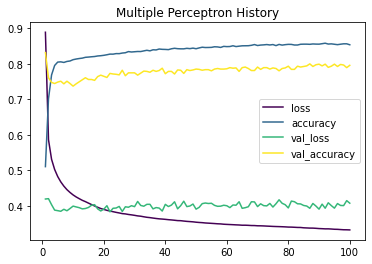

In [134]:
# Plot the history
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")

<AxesSubplot:>

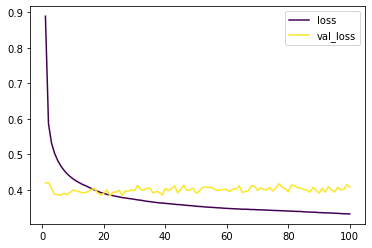

In [135]:
# Plot the loss
multi_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

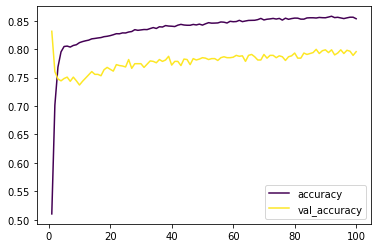

In [136]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [137]:
# Evaluate the model using the test data
multi_model_loss, multi_model_accuracy = multi_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the multiple perceptron model is: {multi_model_loss}, The accuracy is: {multi_model_accuracy}")

 The loss for the multiple perceptron model is: 0.40720847249031067, The accuracy is: 0.7956026196479797


In [138]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_multi = multi_nn_model.predict(X_test_scaled)
y_pred_multi = y_pred_multi.flatten()
y_pred_multi_tf = tf.round(y_pred_multi)

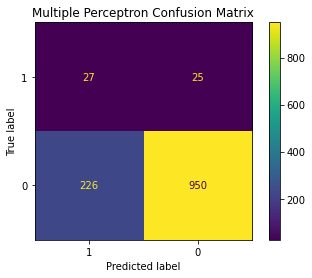

In [139]:
# Display the confusion matrix
multi_nn_cm = confusion_matrix(y_test, y_pred_multi_tf, labels=[1,0])

multi_disp = ConfusionMatrixDisplay(confusion_matrix=multi_nn_cm, display_labels=[1,0])
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")
multi_disp

In [156]:
# Advanced Classification Metrics
# Accuracy
multi_accuracy_score = accuracy_score(y_test, y_pred_multi_tf)
print(f'Accuracy Score of the Multiple Perceptron Model: {multi_accuracy_score}')

# Recall/ Sensitivity
multi_recall_score = recall_score(y_test, y_pred_multi_tf)
print(f'Recall Score of the Multiple Perceptron Model: {multi_recall_score}')

# Specificity
multi_specificity_score = 950 / 1176
print(f'Specifity Score of the Deep Learning Model: {multi_specificity_score}')

# Balanced Accuracy Score
multi_bas = balanced_accuracy_score(y_test, y_pred_multi_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {multi_bas}')

# Precision
multi_precision_score = precision_score(y_test, y_pred_multi_tf)
print(f'Precision Score of the Multiple Perceptron Model: {multi_precision_score}')     
      
# F1 Score
multi_f1_score = f1_score(y_test, y_pred_multi_tf)
print(f'F1 Score Score of the Multiple Perceptron Model: {multi_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {multi_model_loss}')

# Advanced Classification Metrics DF
multi_acm = {"Model Type": ["Multi Perceptron"], "Accuracy":[multi_accuracy_score], "Recall": [multi_recall_score], "Specificity":[multi_specificity_score], 
          "Balanced Accuracy": [multi_bas], "Precision":[multi_precision_score], "F1 Score":[multi_f1_score], "Loss": [multi_model_loss]}
multi_acm_df = pd.DataFrame(data=multi_acm)
multi_acm_df

Accuracy Score of the Multiple Perceptron Model: 0.7956026058631922
Recall Score of the Multiple Perceptron Model: 0.5192307692307693
Specifity Score of the Deep Learning Model: 0.8078231292517006
Balanced Accuracy Score of the Multiple Perceptron Model: 0.663526949241235
Precision Score of the Multiple Perceptron Model: 0.1067193675889328
F1 Score Score of the Multiple Perceptron Model: 0.17704918032786887
Loss of the Multiple Perceptron Model: 0.40720847249031067


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Multi Perceptron,0.795603,0.519231,0.807823,0.663527,0.106719,0.177049,0.407208


## Deep Learning- Feedforward Neural Network

In [141]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50

deep_nn_model = tf.keras.models.Sequential()

# First hidden layer
deep_nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
deep_nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
deep_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
deep_nn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 80)                1760      
                                                                 
 dense_19 (Dense)            (None, 50)                4050      
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5,861
Trainable params: 5,861
Non-trainable params: 0
_________________________________________________________________


In [142]:
# Compile the model
deep_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [143]:
# Train the model
fit_model_deep = deep_nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 1s 3ms/step - loss: 0.1933 - accuracy: 0.9576 - val_loss: 0.1486 - val_accuracy: 0.9577
Epoch 2/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9573 - val_loss: 0.1456 - val_accuracy: 0.9577
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1423 - accuracy: 0.9573 - val_loss: 0.1408 - val_accuracy: 0.9577
Epoch 4/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1389 - accuracy: 0.9573 - val_loss: 0.1418 - val_accuracy: 0.9577
Epoch 5/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9573 - val_loss: 0.1407 - val_accuracy: 0.9577
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9573 - val_loss: 0.1414 - val_accuracy: 0.9568
Epoch 7/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9579 - val_loss: 0.1430 - val_accuracy: 0.9577

Epoch 58/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9745 - val_loss: 0.2238 - val_accuracy: 0.9487
Epoch 59/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9745 - val_loss: 0.2369 - val_accuracy: 0.9503
Epoch 60/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9742 - val_loss: 0.2388 - val_accuracy: 0.9422
Epoch 61/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9747 - val_loss: 0.2331 - val_accuracy: 0.9487
Epoch 62/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9736 - val_loss: 0.2413 - val_accuracy: 0.9528
Epoch 63/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9769 - val_loss: 0.2433 - val_accuracy: 0.9487
Epoch 64/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0642 - accuracy: 0.9769 - val_loss: 0.2402 - val_accuracy:

In [144]:
# Create a DataFrame containing training history
deep_history_df = pd.DataFrame(fit_model_deep.history, index=range(1,len(fit_model_deep.history["loss"])+1))
deep_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.193261,0.957620,0.148569,0.957655
2,0.148364,0.957349,0.145615,0.957655
3,0.142333,0.957349,0.140758,0.957655
4,0.138931,0.957349,0.141819,0.957655
5,0.135392,0.957349,0.140739,0.957655
...,...,...,...,...
96,0.047705,0.982342,0.316270,0.948697
97,0.045231,0.980440,0.320022,0.951954
98,0.047587,0.981255,0.323105,0.947068
99,0.046094,0.980712,0.327434,0.943811


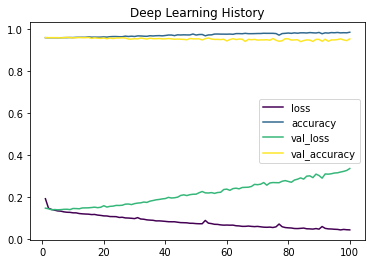

In [145]:
#Plot the history
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")


<AxesSubplot:>

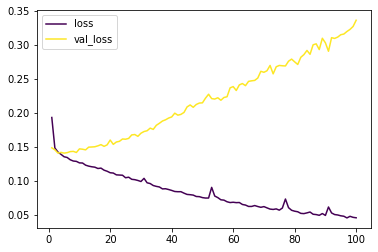

In [146]:
# Plot the loss
deep_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

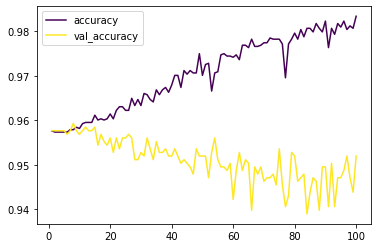

In [147]:
# Plot the accuracy
deep_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [148]:
# Evaluate the model using the test data
dl_model_loss, dl_model_accuracy = deep_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the deep learning model is: {dl_model_loss}, The accuracy is: {dl_model_accuracy}")

 The loss for the deep learning model is: 0.33661404252052307, The accuracy is: 0.9519544243812561


In [149]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_dl = deep_nn_model.predict(X_test_scaled)
y_pred_dl = y_pred_dl.flatten()
y_pred_dl_tf=tf.round(y_pred_dl)

[[   5   47]
 [  12 1164]]


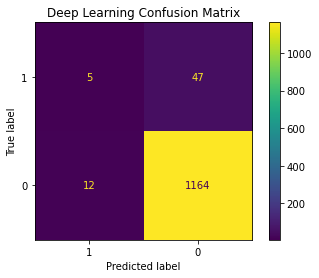

In [150]:
# Display the confusion matrix
dl_nn_cm = confusion_matrix(y_test, y_pred_dl_tf, labels=[1,0])
print (dl_nn_cm)
dl_disp = ConfusionMatrixDisplay(confusion_matrix=dl_nn_cm, display_labels=[1,0])
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [155]:
# Advanced Classification Metrics
# Accuracy
dl_accuracy_score = accuracy_score(y_test, y_pred_dl_tf)
print(f'Accuracy Score of the Deep Learning Model: {dl_accuracy_score}')

## Recall/Sensitivity
dl_recall_score = recall_score(y_test, y_pred_dl_tf)
print(f'Recall Score of the Deep Learning Model: {dl_recall_score}')

# Specificity
dl_specificity_score = 1164 / 1176
print(f'Specifity Score of the Deep Learning Model: {dl_specificity_score}')

# Balanced Accuracy Score
dl_bas = balanced_accuracy_score(y_test, y_pred_dl_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {dl_bas}')

# Precision
dl_precision_score = precision_score(y_test, y_pred_dl_tf)
print(f'Precision Score of the Deep Learning Model: {dl_precision_score}')     
      
# F1 Score
dl_f1_score = f1_score(y_test, y_pred_dl_tf)
print(f'F1 Score Score of the Deep Learning Model: {dl_f1_score}')

# Loss Score
print(f'Loss of the Deep Learning Model: {dl_model_loss}')

# Advanced Classification Metrics DF
dl_acm = {"Model Type": ["Deep Learning"], "Accuracy":[dl_accuracy_score], "Recall": [dl_recall_score], "Specificity":[dl_specificity_score], 
          "Balanced Accuracy": [dl_bas], "Precision":[dl_precision_score], "F1 Score":[dl_f1_score], "Loss": [dl_model_loss]}
dl_acm_df = pd.DataFrame(data=dl_acm)
dl_acm_df

Accuracy Score of the Deep Learning Model: 0.9519543973941368
Recall Score of the Deep Learning Model: 0.09615384615384616
Specifity Score of the Deep Learning Model: 0.9897959183673469
Balanced Accuracy Score of the Multiple Perceptron Model: 0.5429748822605965
Precision Score of the Deep Learning Model: 0.29411764705882354
F1 Score Score of the Deep Learning Model: 0.14492753623188406
Loss of the Deep Learning Model: 0.33661404252052307


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Deep Learning,0.951954,0.096154,0.989796,0.542975,0.294118,0.144928,0.336614


## Comparison of the Models

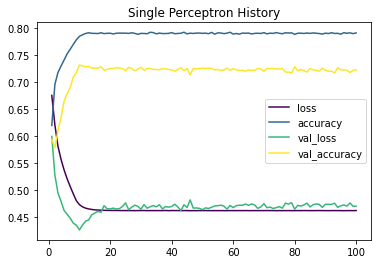

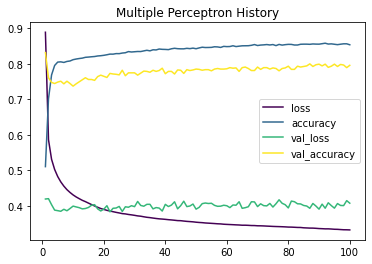

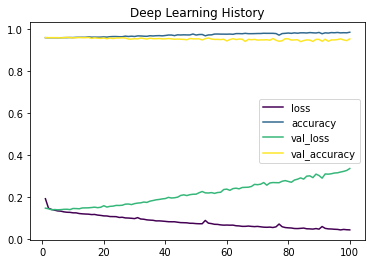

In [152]:
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")

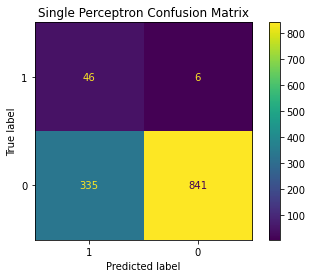

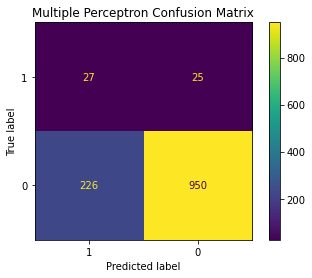

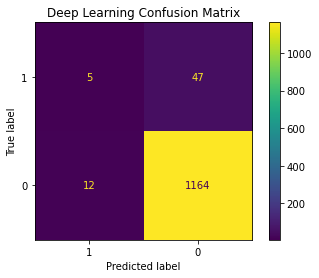

In [153]:
# Single Perceptron Confusion Matrix
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")

# Multiple Perceptron Confusion Matrix
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")

# Deep Learning Confusion Matrix
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [158]:
# Total Advanced Classification Metrics DF
total_acm = ({"Model Type": "Single Perceptron", "Accuracy":nn_accuracy_score, "Recall": nn_recall_score, "Specificity":nn_specificity_score, 
          "Balanced Accuracy": nn_bas, "Precision":nn_precision_score, "F1 Score":nn_f1_score, "Loss": nn_model_loss }, {"Model Type": "Multi Perceptron", "Accuracy":multi_accuracy_score, "Recall": multi_recall_score, "Specificity":multi_specificity_score, 
          "Balanced Accuracy": multi_bas, "Precision":multi_precision_score, "F1 Score":multi_f1_score, "Loss": multi_model_loss}, {"Model Type": "Deep Learning", "Accuracy":dl_accuracy_score, "Recall": dl_recall_score, "Specificity":dl_specificity_score, 
          "Balanced Accuracy": dl_bas, "Precision":dl_precision_score, "F1 Score":dl_f1_score, "Loss": dl_model_loss})
total_acm_df = pd.DataFrame(data=total_acm)
total_acm_df

,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.722313,0.884615,0.715136,0.799876,0.120735,0.212471,0.470068
1,Multi Perceptron,0.795603,0.519231,0.807823,0.663527,0.106719,0.177049,0.407208
2,Deep Learning,0.951954,0.096154,0.989796,0.542975,0.294118,0.144928,0.336614
